# Intro to Deep Learning Project

Submitted By:

1. Parthiv Borgohain (EID:pb25347)

2. Saurabh Arora (EID:sa55445)

3. Rajshree Mishra (EID:rm62528)

4. Harshit Jain (EID:hj7892)


### Exploring the dataset

<p>Reading the image data and their corresponding captions from the flick dataset folder. Showing the image and captions to get the insighs of the data. Dowload link for the dataset used <a href="https://www.kaggle.com/adityajn105/flickr8k">here</a></p>

In [36]:
#location of the data 
data_location =  "../input/flickr8k"
!ls $data_location

Images	captions.txt


In [37]:
#reading the text data 
import pandas as pd
caption_file = data_location + '/captions.txt'
df = pd.read_csv(caption_file)
print("There are {} image to captions".format(len(df)))
df.head(7)

There are 40455 image to captions


image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   
5  1001773457_577c3a7d70.jpg   
6  1001773457_577c3a7d70.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...  
5         A black dog and a spotted dog are fighting  
6  A black dog and a tri-colored dog playing with...

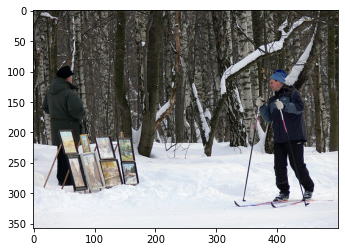

Caption: A man skis past another man displaying paintings in the snow .
Caption: A person wearing skis looking at framed pictures set up in the snow .
Caption: A skier looks at framed pictures in the snow next to trees .
Caption: Man on skis looking at artwork for sale in the snow
Caption: A collage of one person climbing a cliff .


In [38]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#select any index from the whole dataset 
#single image has 5 captions
#so, select indx as: 1,6,11,16...
data_idx = 56

#eg path to be plot: ../input/flickr8k/Images/1000268201_693b08cb0e.jpg
image_path = data_location+"/Images/"+df.iloc[data_idx,0]
img=mpimg.imread(image_path)
plt.imshow(img)
plt.show()

#image consits of 5 captions,
#showing all 5 captions of the image of the given idx 
for i in range(data_idx,data_idx+5):
    print("Caption:",df.iloc[i,1])


# Custom dataset with Vocabulary

<p>Writing the custom torch dataset class so, that we can abastract out the dataloading steps during the training and validation process</p>
<p>Here, dataloader is created which gives the batch of image and its captions with following processing done:</p>

<li>caption word tokenized to unique numbers</li>
<li>vocab instance created to store all the relivent words in the datasets</li>
<li>each batch, caption padded to have same sequence length</li>
<li>image resized to the desired size and converted into captions</li>

<br><p>In this way the dataprocessing is done, and the dataloader is ready to be used with <b>Pytorch</b></p>

In [39]:
#imports 
import os
from collections import Counter
import spacy
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as T

from PIL import Image

In [40]:
#using spacy for the better text tokenization 
spacy_eng = spacy.load("en")

#example
text = "This is a good place to find a city"
[token.text.lower() for token in spacy_eng.tokenizer(text)]

['this', 'is', 'a', 'good', 'place', 'to', 'find', 'a', 'city']

In [41]:
class Vocabulary:
    def __init__(self,freq_threshold):
        #setting the pre-reserved tokens int to string tokens
        self.itos = {0:"<PAD>",1:"<SOS>",2:"<EOS>",3:"<UNK>"}
        
        #string to int tokens
        #its reverse dict self.itos
        self.stoi = {v:k for k,v in self.itos.items()}
        
        self.freq_threshold = freq_threshold
        
    def __len__(self): return len(self.itos)
    
    @staticmethod
    def tokenize(text):
        return [token.text.lower() for token in spacy_eng.tokenizer(text)]
    
    def build_vocab(self, sentence_list):
        frequencies = Counter()
        idx = 4
        
        for sentence in sentence_list:
            for word in self.tokenize(sentence):
                frequencies[word] += 1
                
                #add the word to the vocab if it reaches minum frequecy threshold
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1
    
    def numericalize(self,text):
        """ For each word in the text corresponding index token for that word form the vocab built as list """
        tokenized_text = self.tokenize(text)
        return [ self.stoi[token] if token in self.stoi else self.stoi["<UNK>"] for token in tokenized_text ]    

In [42]:
#testing the vicab class 
v = Vocabulary(freq_threshold=1)

v.build_vocab(["This is a good place to find a city"])
print(v.stoi)
print(v.numericalize("This is a good place to find a city here!!"))

{'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3, 'this': 4, 'is': 5, 'a': 6, 'good': 7, 'place': 8, 'to': 9, 'find': 10, 'city': 11}
[4, 5, 6, 7, 8, 9, 10, 6, 11, 3, 3, 3]


In [43]:
class FlickrDataset(Dataset):
    """
    FlickrDataset
    """
    def __init__(self,root_dir,captions_file,transform=None,freq_threshold=5):
        self.root_dir = root_dir
        self.df = pd.read_csv(caption_file)
        self.transform = transform
        
        #Get image and caption colum from the dataframe
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]
        
        #Initialize vocabulary and build vocab
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocab(self.captions.tolist())
        
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        caption = self.captions[idx]
        img_name = self.imgs[idx]
        img_location = os.path.join(self.root_dir,img_name)
        img = Image.open(img_location).convert("RGB")
        
        #apply the transfromation to the image
        if self.transform is not None:
            img = self.transform(img)
        
        #numericalize the caption text
        caption_vec = []
        caption_vec += [self.vocab.stoi["<SOS>"]]
        caption_vec += self.vocab.numericalize(caption)
        caption_vec += [self.vocab.stoi["<EOS>"]]
        
        return img, torch.tensor(caption_vec)

In [44]:
#show the tensor image
import matplotlib.pyplot as plt
def show_image(img, title=None):
    """Imshow for Tensor."""
    
    #unnormalize 
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    
    
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

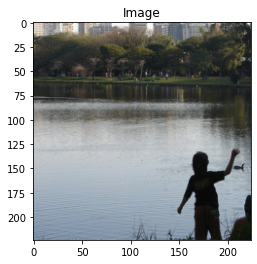

Token: tensor([  1,   4,  28,  16,   4,  80,  34,  19, 766, 163,   8,   4, 250, 215,
          5,   2])
Sentence:
['<SOS>', 'a', 'child', 'and', 'a', 'woman', 'are', 'at', 'waters', 'edge', 'in', 'a', 'big', 'city', '.', '<EOS>']


In [45]:
#defining the transform to be applied
transforms = T.Compose([
    T.Resize(226),                     
    T.RandomCrop(224),                 
    T.ToTensor(),                               
    T.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
])

#testing the dataset class
dataset =  FlickrDataset(
    root_dir = data_location+"/Images",
    captions_file = data_location+"/captions.txt",
    transform=transforms
)



img, caps = dataset[80]
show_image(img,"Image")
print("Token:",caps)
print("Sentence:")
print([dataset.vocab.itos[token] for token in caps.tolist()])

In [46]:
class CapsCollate:
    """
    Collate to apply the padding to the captions with dataloader
    """
    def __init__(self,pad_idx,batch_first=False):
        self.pad_idx = pad_idx
        self.batch_first = batch_first
    
    def __call__(self,batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs,dim=0)
        
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=self.batch_first, padding_value=self.pad_idx)
        return imgs,targets

In [47]:
#writing the dataloader
#setting the constants
BATCH_SIZE = 4
NUM_WORKER = 1

#token to represent the padding
pad_idx = dataset.vocab.stoi["<PAD>"]

data_loader = DataLoader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=True,
    collate_fn=CapsCollate(pad_idx=pad_idx,batch_first=True)
)

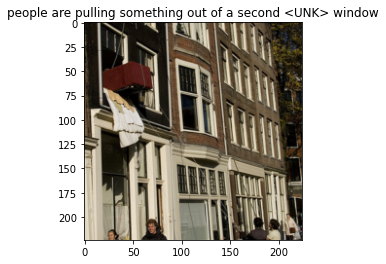

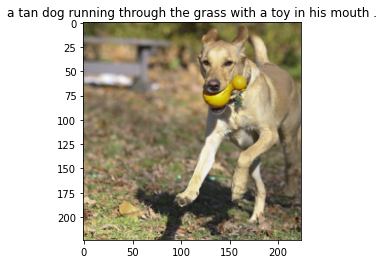

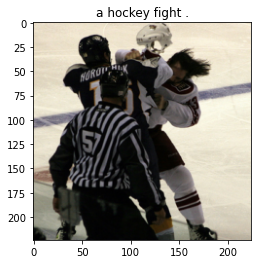

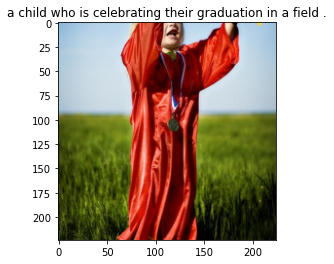

In [48]:
#generating the iterator from the dataloader
dataiter = iter(data_loader)

#getting the next batch
batch = next(dataiter)

#unpacking the batch
images, captions = batch

#showing info of image in single batch
for i in range(BATCH_SIZE):
    img,cap = images[i],captions[i]
    caption_label = [dataset.vocab.itos[token] for token in cap.tolist()]
    eos_index = caption_label.index('<EOS>')
    caption_label = caption_label[1:eos_index]
    caption_label = ' '.join(caption_label)                      
    show_image(img,caption_label)
    plt.show()

# Attention Model configuration

The model consists of three modules: EncoderCNN, Attention, and DecoderRNN.

In [49]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.models as models
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as T

In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [51]:
# feature map representation from ResNet model will be used as input to our Attention model
class EncoderCNN(nn.Module):
    def __init__(self):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        modules = list(resnet.children())[:-2] # everythin except last Conv block
        self.resnet = nn.Sequential(*modules)
        

    def forward(self, images):
        features = self.resnet(images)                                    #(batch_size,2048,7,7)
        features = features.permute(0, 2, 3, 1)                           #(batch_size,7,7,2048)
        features = features.view(features.size(0), -1, features.size(-1)) #(batch_size,49,2048)
        return features

In [52]:
#Bahdanau Attention - allows our Decoder to pay attention to certain features (important parts)
class Attention(nn.Module):
    def __init__(self, encoder_dim,decoder_dim,attention_dim):
        super(Attention, self).__init__()
        
        self.attention_dim = attention_dim
        
        # we pass encoder/decoder hidden states to weights layer
        self.W = nn.Linear(decoder_dim,attention_dim)
        self.U = nn.Linear(encoder_dim,attention_dim)
        
        # generate alignment scores
        self.A = nn.Linear(attention_dim,1)
        
    # as input we accept feature map representation  and prev decoder hidden state  
    def forward(self, features, hidden_state):
        u_hs = self.U(features)     #(batch_size,num_layers,attention_dim)
        w_ah = self.W(hidden_state) #(batch_size,attention_dim)
        
        # adding one mode dimension for combined states
        combined_states = torch.tanh(u_hs + w_ah.unsqueeze(1)) #(batch_size,num_layers,attemtion_dim)
        
        attention_scores = self.A(combined_states)         #(batch_size,num_layers,1)
        attention_scores = attention_scores.squeeze(2)     #(batch_size,num_layers)
        
        # conversion to probabilities using softmax
        alpha = F.softmax(attention_scores,dim=1)          #(batch_size,num_layers)
        
        # generating the context vector
        attention_weights = features * alpha.unsqueeze(2)  #(batch_size,num_layers,features_dim)
        attention_weights = attention_weights.sum(dim=1)   #(batch_size,num_layers)
        
        return alpha,attention_weights
        


In [53]:
# Attention Decoder module to generate captions
class DecoderRNN(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        
        #save the model param
        self.vocab_size = vocab_size
        self.attention_dim = attention_dim
        self.decoder_dim = decoder_dim
        
        # generate embeddings for words
        self.embedding = nn.Embedding(vocab_size,embed_size)
        self.attention = Attention(encoder_dim,decoder_dim,attention_dim)
        
        # features representation
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  
        self.lstm_cell = nn.LSTMCell(embed_size+encoder_dim,decoder_dim,bias=True)
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)
        
        # linear layer that outputs one-hot vector of predicted word
        self.fcn = nn.Linear(decoder_dim,vocab_size)
        self.drop = nn.Dropout(drop_prob)
        
    # inputs are feature representation and captions (vectors)    
    def forward(self, features, captions):
        
        #vectorize the caption
        embeds = self.embedding(captions)
        
        # Initialize LSTM state
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)
        
        #get the seq length to iterate
        seq_length = len(captions[0])-1 #Exclude the last one
        batch_size = captions.size(0)
        num_features = features.size(1)
        
        # predicted captions in form of one-hot vectors
        preds = torch.zeros(batch_size, seq_length, self.vocab_size).to(device)
        alphas = torch.zeros(batch_size, seq_length,num_features).to(device)
        
        # feed in the input for each time instance along with context vectors
        for s in range(seq_length):
            # first, pass the features and decoder hidden state
            alpha,context = self.attention(features, h)
            
            # lstm input are embeddings repr words and context vectors
            lstm_input = torch.cat((embeds[:, s], context), dim=1)
            
            # hidden state for next time instance
            h, c = self.lstm_cell(lstm_input, (h, c))
            
            # pass through dropout layer
            output = self.fcn(self.drop(h))
            
            # get the prediction and weights
            preds[:,s] = output
            alphas[:,s] = alpha  
        
        return preds, alphas
    
    def generate_caption(self,features,max_len=50,vocab=None):
        # Inference part
        # Given the image features generate the captions
        
        batch_size = features.size(0)
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)
        
        # store the weights
        alphas = []
        
        #starting input
        word = torch.tensor(vocab.stoi['<SOS>']).view(1,-1).to(device)
        embeds = self.embedding(word)

        # captions generated 
        captions = []
        
        for i in range(max_len):
            # take encoder output and compute the current attention
            alpha,context = self.attention(features, h)
            
            #store the apla score
            alphas.append(alpha.cpu().detach().numpy())
            
            # conatenation of current state embeddings and context vectors
            lstm_input = torch.cat((embeds[:, 0], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
            output = self.fcn(self.drop(h))
            output = output.view(batch_size,-1)
            
            #select the word with most val
            predicted_word_idx = output.argmax(dim=1)
            
            #save the generated word
            captions.append(predicted_word_idx.item())
            
            #end if <EOS detected>
            if vocab.itos[predicted_word_idx.item()] == "<EOS>":
                break
            
            #send generated word as the next caption
            embeds = self.embedding(predicted_word_idx.unsqueeze(0))
        
        #covert the vocab idx to words and return sentence
        return [vocab.itos[idx] for idx in captions],alphas
    
    # features from encoder CNN 
    def init_hidden_state(self, encoder_out):
        batch_size = encoder_out.size(0)
        h = torch.zeros(batch_size, self.decoder_dim).to(encoder_out.device)
        c = torch.zeros(batch_size, self.decoder_dim).to(encoder_out.device)
        return h, c

In [54]:
# Seq2Seq model to generate image captions

class EncoderDecoder(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        # encoder doesn't need any params to specify
        self.encoder = EncoderCNN()
        # decoder params need to be specified
        self.decoder = DecoderRNN(
            embed_size=embed_size,
            vocab_size = len(dataset.vocab),
            attention_dim=attention_dim,
            encoder_dim=encoder_dim,
            decoder_dim=decoder_dim
        )
    
    def forward(self, images, captions):
        # pass the images through encoder to ger feature representations
        features = self.encoder(images)
        # features and captions are passed to decoder
        outputs = self.decoder(features, captions)
        return outputs


# Hyperparameter and Model initialization

In [55]:
# Hyperparams to tweak

embed_size=500
vocab_size = len(dataset.vocab)
attention_dim=256
encoder_dim=2048
decoder_dim=512
learning_rate = 3e-4

In [64]:
# Seq2Seq model initialization

model = EncoderDecoder(
    embed_size=500,
    vocab_size = len(dataset.vocab),
    attention_dim=256,
    encoder_dim=2048,
    decoder_dim=512
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [57]:
# helper function to save the model
def save_model(model,num_epochs):
    model_state = {
        'num_epochs':num_epochs,
        'embed_size':embed_size,
        'vocab_size':len(dataset.vocab),
        'attention_dim':attention_dim,
        'encoder_dim':encoder_dim,
        'decoder_dim':decoder_dim,
        'state_dict':model.state_dict()
    }

    torch.save(model_state,'attention_model_state.pth')

# Training the Model

Epoch: 1 Batch: 1000 loss: 3.37218
Epoch: 1 Batch: 2000 loss: 3.61371
Epoch: 1 Batch: 3000 loss: 3.45702
Epoch: 1 Batch: 4000 loss: 3.79346
Epoch: 1 Batch: 5000 loss: 3.08210
Epoch: 1 Batch: 6000 loss: 2.87244
Epoch: 1 Batch: 7000 loss: 2.53342
Epoch: 1 Batch: 8000 loss: 3.28051
Epoch: 1 Batch: 9000 loss: 2.70902
Epoch: 1 Batch: 10000 loss: 3.15267


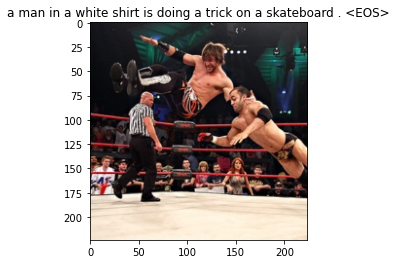

Epoch: 2 Batch: 1000 loss: 2.64868
Epoch: 2 Batch: 2000 loss: 2.80299
Epoch: 2 Batch: 3000 loss: 3.15935
Epoch: 2 Batch: 4000 loss: 3.80683
Epoch: 2 Batch: 5000 loss: 2.58536
Epoch: 2 Batch: 6000 loss: 2.65048
Epoch: 2 Batch: 7000 loss: 2.74404
Epoch: 2 Batch: 8000 loss: 3.13000
Epoch: 2 Batch: 9000 loss: 3.42501
Epoch: 2 Batch: 10000 loss: 3.06420


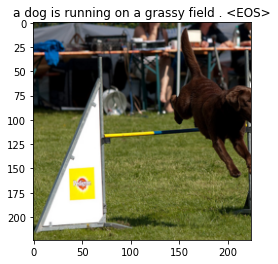

Epoch: 3 Batch: 1000 loss: 2.75039
Epoch: 3 Batch: 2000 loss: 3.09465
Epoch: 3 Batch: 3000 loss: 2.98556
Epoch: 3 Batch: 4000 loss: 2.93015
Epoch: 3 Batch: 5000 loss: 2.18489
Epoch: 3 Batch: 6000 loss: 2.97829
Epoch: 3 Batch: 7000 loss: 2.30461
Epoch: 3 Batch: 8000 loss: 2.92948
Epoch: 3 Batch: 9000 loss: 3.60111
Epoch: 3 Batch: 10000 loss: 2.61482


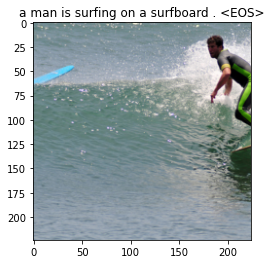

Epoch: 4 Batch: 1000 loss: 2.72071
Epoch: 4 Batch: 2000 loss: 2.24349
Epoch: 4 Batch: 3000 loss: 2.45712
Epoch: 4 Batch: 4000 loss: 2.32764
Epoch: 4 Batch: 5000 loss: 2.26539
Epoch: 4 Batch: 6000 loss: 2.40374
Epoch: 4 Batch: 7000 loss: 2.86726
Epoch: 4 Batch: 8000 loss: 3.19855
Epoch: 4 Batch: 9000 loss: 3.17005
Epoch: 4 Batch: 10000 loss: 2.43262


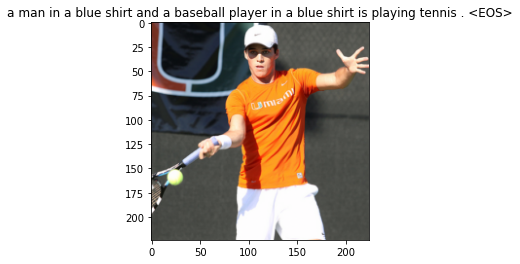

Epoch: 5 Batch: 1000 loss: 2.31412
Epoch: 5 Batch: 2000 loss: 2.24726
Epoch: 5 Batch: 3000 loss: 2.71607
Epoch: 5 Batch: 4000 loss: 2.24613
Epoch: 5 Batch: 5000 loss: 2.04682
Epoch: 5 Batch: 6000 loss: 2.78040
Epoch: 5 Batch: 7000 loss: 2.63184
Epoch: 5 Batch: 8000 loss: 2.02660
Epoch: 5 Batch: 9000 loss: 2.84695
Epoch: 5 Batch: 10000 loss: 2.62580


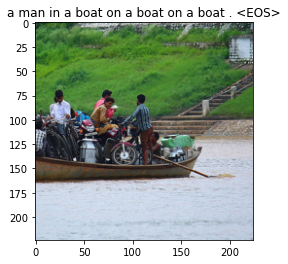

Epoch: 6 Batch: 1000 loss: 2.87495
Epoch: 6 Batch: 2000 loss: 2.51454
Epoch: 6 Batch: 3000 loss: 2.95502
Epoch: 6 Batch: 4000 loss: 1.85995
Epoch: 6 Batch: 5000 loss: 2.62647
Epoch: 6 Batch: 6000 loss: 1.83075
Epoch: 6 Batch: 7000 loss: 2.03394
Epoch: 6 Batch: 8000 loss: 2.81368
Epoch: 6 Batch: 9000 loss: 3.40757
Epoch: 6 Batch: 10000 loss: 1.88331


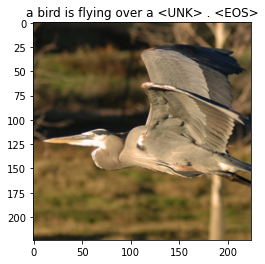

Epoch: 7 Batch: 1000 loss: 2.48533
Epoch: 7 Batch: 2000 loss: 1.81690
Epoch: 7 Batch: 3000 loss: 1.63730
Epoch: 7 Batch: 4000 loss: 2.53819
Epoch: 7 Batch: 5000 loss: 2.43093
Epoch: 7 Batch: 6000 loss: 2.40118
Epoch: 7 Batch: 7000 loss: 2.09824
Epoch: 7 Batch: 8000 loss: 2.37117
Epoch: 7 Batch: 9000 loss: 2.02520
Epoch: 7 Batch: 10000 loss: 2.89072


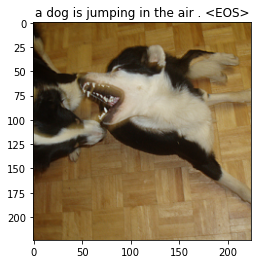

Epoch: 8 Batch: 1000 loss: 3.03232
Epoch: 8 Batch: 2000 loss: 2.96748
Epoch: 8 Batch: 3000 loss: 2.33782
Epoch: 8 Batch: 4000 loss: 2.73807
Epoch: 8 Batch: 5000 loss: 3.09037
Epoch: 8 Batch: 6000 loss: 2.69366
Epoch: 8 Batch: 7000 loss: 1.98898
Epoch: 8 Batch: 8000 loss: 2.27271
Epoch: 8 Batch: 9000 loss: 2.15937
Epoch: 8 Batch: 10000 loss: 2.35859


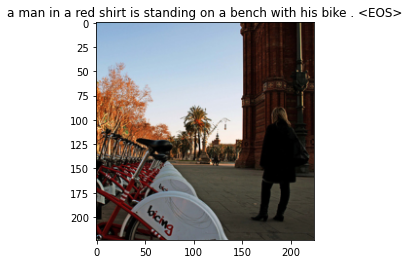

Epoch: 9 Batch: 1000 loss: 1.66527
Epoch: 9 Batch: 2000 loss: 2.53829
Epoch: 9 Batch: 3000 loss: 2.00985
Epoch: 9 Batch: 4000 loss: 3.04622
Epoch: 9 Batch: 5000 loss: 2.12393
Epoch: 9 Batch: 6000 loss: 2.86831
Epoch: 9 Batch: 7000 loss: 2.47385
Epoch: 9 Batch: 8000 loss: 2.29576
Epoch: 9 Batch: 9000 loss: 2.45199
Epoch: 9 Batch: 10000 loss: 2.38494


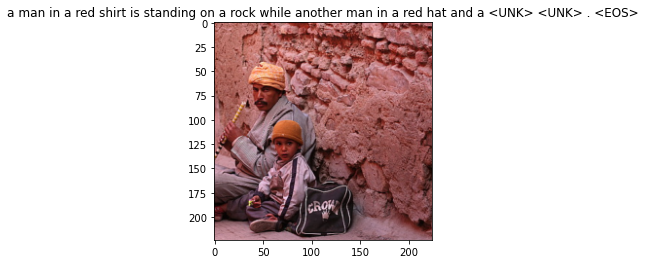

Epoch: 10 Batch: 1000 loss: 1.83841
Epoch: 10 Batch: 2000 loss: 2.05515
Epoch: 10 Batch: 3000 loss: 2.34801
Epoch: 10 Batch: 4000 loss: 2.64092
Epoch: 10 Batch: 5000 loss: 2.12850
Epoch: 10 Batch: 6000 loss: 2.51591
Epoch: 10 Batch: 7000 loss: 1.97182
Epoch: 10 Batch: 8000 loss: 2.37119
Epoch: 10 Batch: 9000 loss: 1.94496
Epoch: 10 Batch: 10000 loss: 2.67778


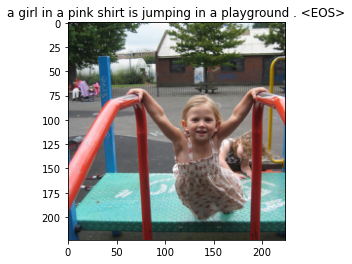

Epoch: 11 Batch: 1000 loss: 2.38541
Epoch: 11 Batch: 2000 loss: 2.17650
Epoch: 11 Batch: 3000 loss: 2.09429
Epoch: 11 Batch: 4000 loss: 2.19879
Epoch: 11 Batch: 5000 loss: 2.69083
Epoch: 11 Batch: 6000 loss: 1.64192
Epoch: 11 Batch: 7000 loss: 2.30487
Epoch: 11 Batch: 8000 loss: 2.04933
Epoch: 11 Batch: 9000 loss: 2.38109
Epoch: 11 Batch: 10000 loss: 2.37224


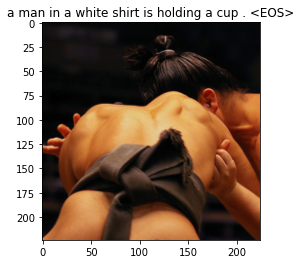

Epoch: 12 Batch: 1000 loss: 2.39052
Epoch: 12 Batch: 2000 loss: 2.12871
Epoch: 12 Batch: 3000 loss: 2.21338
Epoch: 12 Batch: 4000 loss: 1.80446
Epoch: 12 Batch: 5000 loss: 2.03891
Epoch: 12 Batch: 6000 loss: 2.09131
Epoch: 12 Batch: 7000 loss: 2.38935
Epoch: 12 Batch: 8000 loss: 3.02274
Epoch: 12 Batch: 9000 loss: 1.82872
Epoch: 12 Batch: 10000 loss: 2.52202


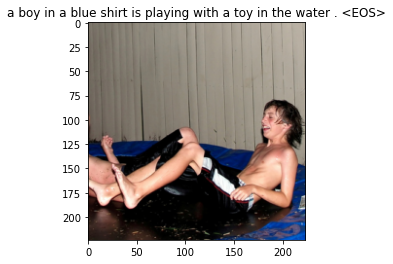

Epoch: 13 Batch: 1000 loss: 1.60906
Epoch: 13 Batch: 2000 loss: 2.75349
Epoch: 13 Batch: 3000 loss: 2.24516
Epoch: 13 Batch: 4000 loss: 2.54971
Epoch: 13 Batch: 5000 loss: 2.02909
Epoch: 13 Batch: 6000 loss: 2.57325
Epoch: 13 Batch: 7000 loss: 1.70406
Epoch: 13 Batch: 8000 loss: 2.03365
Epoch: 13 Batch: 9000 loss: 2.20396
Epoch: 13 Batch: 10000 loss: 1.90685


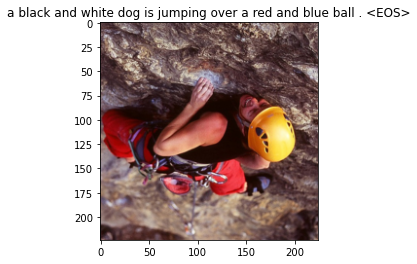

Epoch: 14 Batch: 1000 loss: 2.01006
Epoch: 14 Batch: 2000 loss: 2.41116
Epoch: 14 Batch: 3000 loss: 1.69500
Epoch: 14 Batch: 4000 loss: 2.34863
Epoch: 14 Batch: 5000 loss: 1.73159
Epoch: 14 Batch: 6000 loss: 1.79994
Epoch: 14 Batch: 7000 loss: 2.07699
Epoch: 14 Batch: 8000 loss: 1.92516
Epoch: 14 Batch: 9000 loss: 2.35379
Epoch: 14 Batch: 10000 loss: 2.75331


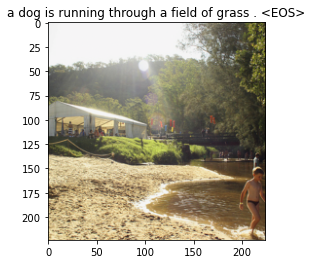

Epoch: 15 Batch: 1000 loss: 1.60197
Epoch: 15 Batch: 2000 loss: 2.24949
Epoch: 15 Batch: 3000 loss: 2.00220
Epoch: 15 Batch: 4000 loss: 2.30038
Epoch: 15 Batch: 5000 loss: 1.83588
Epoch: 15 Batch: 6000 loss: 2.10066
Epoch: 15 Batch: 7000 loss: 2.23125
Epoch: 15 Batch: 8000 loss: 2.81364
Epoch: 15 Batch: 9000 loss: 2.07196
Epoch: 15 Batch: 10000 loss: 2.80437


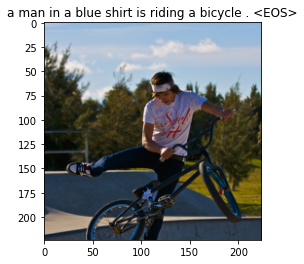

Epoch: 16 Batch: 1000 loss: 2.08055
Epoch: 16 Batch: 2000 loss: 2.22334
Epoch: 16 Batch: 3000 loss: 2.00832
Epoch: 16 Batch: 4000 loss: 2.27164
Epoch: 16 Batch: 5000 loss: 2.55209
Epoch: 16 Batch: 6000 loss: 2.39230
Epoch: 16 Batch: 7000 loss: 1.69196
Epoch: 16 Batch: 8000 loss: 2.19104
Epoch: 16 Batch: 9000 loss: 1.88754
Epoch: 16 Batch: 10000 loss: 2.01538


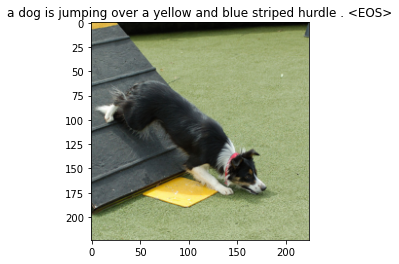

Epoch: 17 Batch: 1000 loss: 1.68455
Epoch: 17 Batch: 2000 loss: 2.09832
Epoch: 17 Batch: 3000 loss: 2.75112
Epoch: 17 Batch: 4000 loss: 1.92238
Epoch: 17 Batch: 5000 loss: 2.53702
Epoch: 17 Batch: 6000 loss: 2.60931
Epoch: 17 Batch: 7000 loss: 1.94704
Epoch: 17 Batch: 8000 loss: 2.42635
Epoch: 17 Batch: 9000 loss: 2.13173
Epoch: 17 Batch: 10000 loss: 1.82807


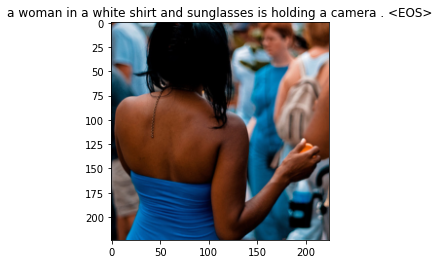

Epoch: 18 Batch: 1000 loss: 2.05887
Epoch: 18 Batch: 2000 loss: 2.25257
Epoch: 18 Batch: 3000 loss: 1.76122
Epoch: 18 Batch: 4000 loss: 2.01883
Epoch: 18 Batch: 5000 loss: 2.59303
Epoch: 18 Batch: 6000 loss: 2.09897
Epoch: 18 Batch: 7000 loss: 2.33634
Epoch: 18 Batch: 8000 loss: 2.41598
Epoch: 18 Batch: 9000 loss: 1.87197
Epoch: 18 Batch: 10000 loss: 1.71316


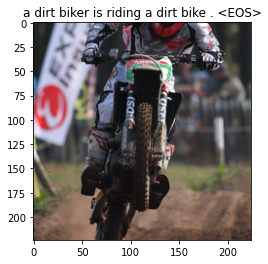

Epoch: 19 Batch: 1000 loss: 2.67852
Epoch: 19 Batch: 2000 loss: 1.71517
Epoch: 19 Batch: 3000 loss: 1.76281
Epoch: 19 Batch: 4000 loss: 2.00520
Epoch: 19 Batch: 5000 loss: 2.16853
Epoch: 19 Batch: 6000 loss: 1.50632
Epoch: 19 Batch: 7000 loss: 2.14305
Epoch: 19 Batch: 8000 loss: 2.00791
Epoch: 19 Batch: 9000 loss: 2.07732
Epoch: 19 Batch: 10000 loss: 1.77569


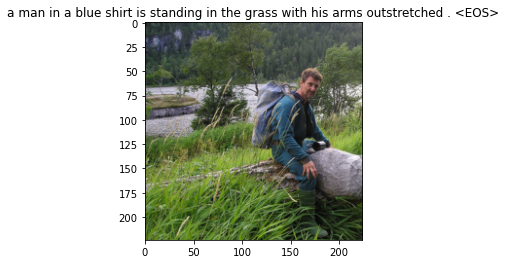

Epoch: 20 Batch: 1000 loss: 1.47532
Epoch: 20 Batch: 2000 loss: 1.66467
Epoch: 20 Batch: 3000 loss: 1.80867
Epoch: 20 Batch: 4000 loss: 2.07416
Epoch: 20 Batch: 5000 loss: 1.59369
Epoch: 20 Batch: 6000 loss: 2.39097
Epoch: 20 Batch: 7000 loss: 1.65341
Epoch: 20 Batch: 8000 loss: 2.48203
Epoch: 20 Batch: 9000 loss: 2.67673
Epoch: 20 Batch: 10000 loss: 2.02355


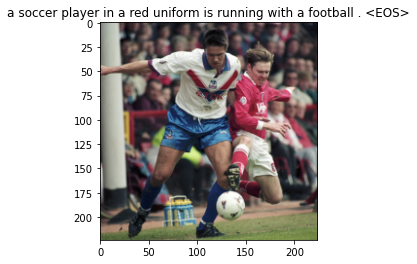

Epoch: 21 Batch: 1000 loss: 1.92446
Epoch: 21 Batch: 2000 loss: 1.82069
Epoch: 21 Batch: 3000 loss: 2.11890
Epoch: 21 Batch: 4000 loss: 1.91638
Epoch: 21 Batch: 5000 loss: 1.87271
Epoch: 21 Batch: 6000 loss: 1.94453
Epoch: 21 Batch: 7000 loss: 2.05243
Epoch: 21 Batch: 8000 loss: 2.24707
Epoch: 21 Batch: 9000 loss: 2.83059
Epoch: 21 Batch: 10000 loss: 1.75943


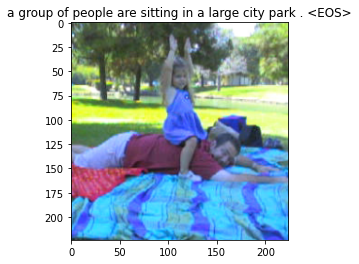

Epoch: 22 Batch: 1000 loss: 1.91589
Epoch: 22 Batch: 2000 loss: 2.60763
Epoch: 22 Batch: 3000 loss: 1.90239
Epoch: 22 Batch: 4000 loss: 2.08435
Epoch: 22 Batch: 5000 loss: 1.98669
Epoch: 22 Batch: 6000 loss: 1.62525
Epoch: 22 Batch: 7000 loss: 1.86657
Epoch: 22 Batch: 8000 loss: 2.62829
Epoch: 22 Batch: 9000 loss: 1.92154
Epoch: 22 Batch: 10000 loss: 1.58822


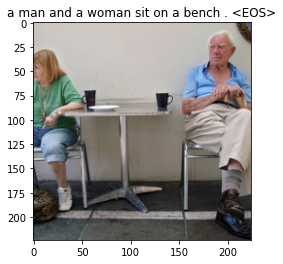

Epoch: 23 Batch: 1000 loss: 2.12380
Epoch: 23 Batch: 2000 loss: 2.13426
Epoch: 23 Batch: 3000 loss: 2.49265
Epoch: 23 Batch: 4000 loss: 2.15000
Epoch: 23 Batch: 5000 loss: 1.77598
Epoch: 23 Batch: 6000 loss: 1.48689
Epoch: 23 Batch: 7000 loss: 1.89643
Epoch: 23 Batch: 8000 loss: 1.70762
Epoch: 23 Batch: 9000 loss: 1.84619
Epoch: 23 Batch: 10000 loss: 2.42158


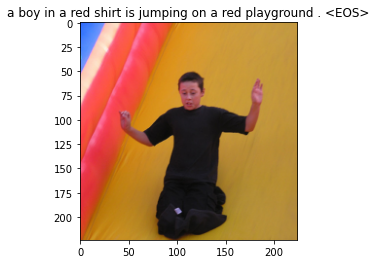

Epoch: 24 Batch: 1000 loss: 1.44111
Epoch: 24 Batch: 2000 loss: 2.25616
Epoch: 24 Batch: 3000 loss: 2.38508
Epoch: 24 Batch: 4000 loss: 2.10348
Epoch: 24 Batch: 5000 loss: 1.47220
Epoch: 24 Batch: 6000 loss: 2.51185
Epoch: 24 Batch: 7000 loss: 2.64683
Epoch: 24 Batch: 8000 loss: 2.06244
Epoch: 24 Batch: 9000 loss: 2.48059
Epoch: 24 Batch: 10000 loss: 2.40910


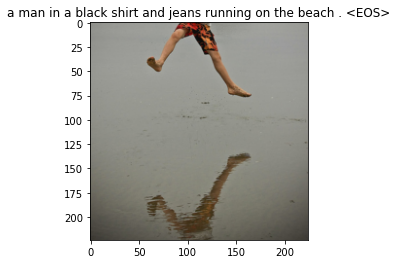

Epoch: 25 Batch: 1000 loss: 2.07386
Epoch: 25 Batch: 2000 loss: 2.29022
Epoch: 25 Batch: 3000 loss: 2.07162
Epoch: 25 Batch: 4000 loss: 1.94167
Epoch: 25 Batch: 5000 loss: 2.44823
Epoch: 25 Batch: 6000 loss: 1.66335
Epoch: 25 Batch: 7000 loss: 2.35764
Epoch: 25 Batch: 8000 loss: 3.03096
Epoch: 25 Batch: 9000 loss: 1.25443
Epoch: 25 Batch: 10000 loss: 2.31841


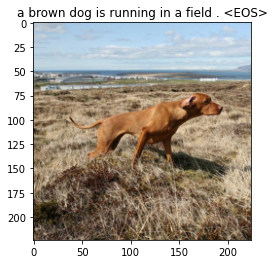

In [23]:
num_epochs = 25
print_every = 1000

for epoch in range(1,num_epochs+1):
    for idx, (image, captions) in enumerate(iter(data_loader)):
        image,captions = image.to(device),captions.to(device)

        # Zero the gradients.
        optimizer.zero_grad()

        # Feed forward
        outputs,attentions = model(image, captions)

        # Calculate the batch loss.
        targets = captions[:,1:]
        loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))

        # Backward pass.
        loss.backward()

        # Update the parameters in the optimizer.
        optimizer.step()

        if (idx+1)%print_every == 0:
            print("Epoch: {} Batch: {} loss: {:.5f}".format(epoch, idx+1, loss.item()))
        
    #generate the caption and display it
    model.eval()
    with torch.no_grad():
        dataiter = iter(data_loader)
        img,_ = next(dataiter)
        features = model.encoder(img[0:1].to(device))
        caps,alphas = model.decoder.generate_caption(features,vocab=dataset.vocab)
        caption = ' '.join(caps)
        show_image(img[0],title=caption)

    model.train()

    #save the latest model after every epoch
    save_model(model,epoch)

# Visualizing the model'a attention

In [65]:
model.load_state_dict(torch.load('../input/weights/attention_model_state.pth')['state_dict'])
#model = torch.load('../input/weights/attention_model_state.pth')

<All keys matched successfully>

In [59]:
# For visualising attentions following helper functions are defined. 
# generate_caps-Given the image generate captions and attention scores show_attention-Plot the attention scores in the image

In [66]:
# generate caption
def get_caps_from(features_tensors):
    #generate the caption
    model.eval()
    with torch.no_grad():
        features = model.encoder(features_tensors.to(device))
        caps,alphas = model.decoder.generate_caption(features,vocab=dataset.vocab)
        caption = ' '.join(caps)
        show_image(features_tensors[0],title=caption)
    
    return caps,alphas

In [67]:
# Show attention
def plot_attention(img, result, attention_plot):
    #untransform
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    temp_image = img

    fig = plt.figure(figsize=(15, 15))

    len_result = len(result)
    for l in range(len_result):
        temp_att = attention_plot[l].reshape(7,7)
        
        ax = fig.add_subplot(len_result//2,len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.7, extent=img.get_extent())
        

    plt.tight_layout()
    plt.show()

In [124]:
import nltk

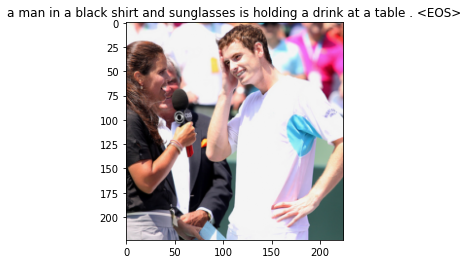

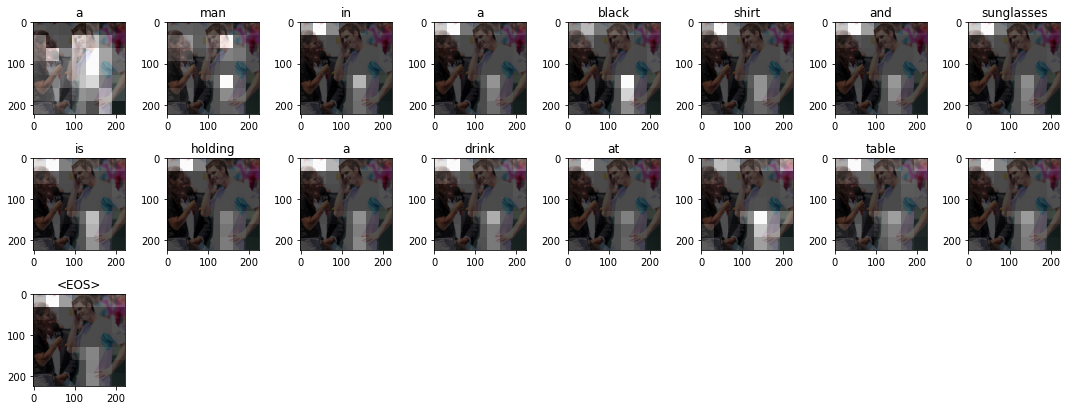

Generated BLEU Score 0.6761043685091208


In [144]:
# show any 1
dataiter = iter(data_loader)
images,_ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas)


tot = []
for i in range(0,len(cap)):
    k = [dataset.vocab.itos[token] for token in cap[i].tolist()]
    tot.append(' '.join(k))

print('Generated BLEU Score',nltk.translate.bleu_score.sentence_bleu(tot,' '.join(caps),weights = (0.5,0.5)))

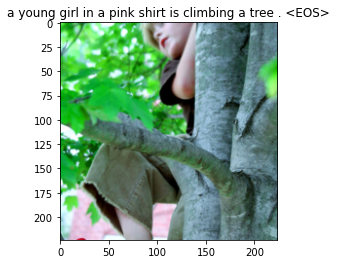

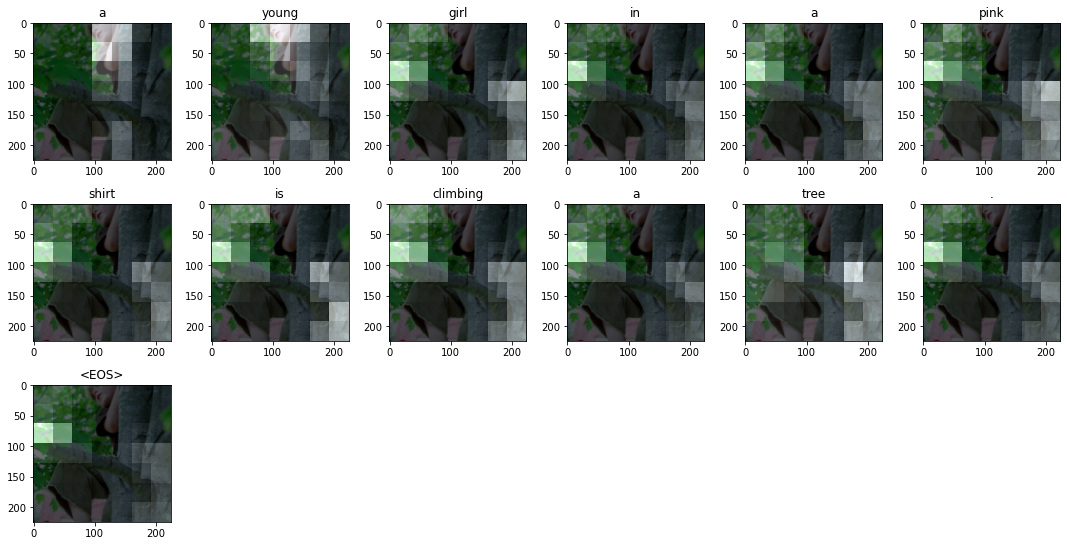

Generated BLEU Score 0.5259627298431272


In [145]:
#show any 1
dataiter = iter(data_loader)
images,_ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas)

tot = []
for i in range(0,len(cap)):
    k = [dataset.vocab.itos[token] for token in cap[i].tolist()]
    tot.append(' '.join(k))

print('Generated BLEU Score',nltk.translate.bleu_score.sentence_bleu(tot,' '.join(caps),weights = (0.5,0.5)))

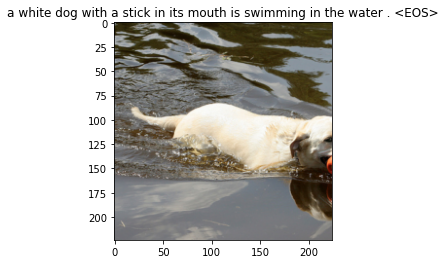

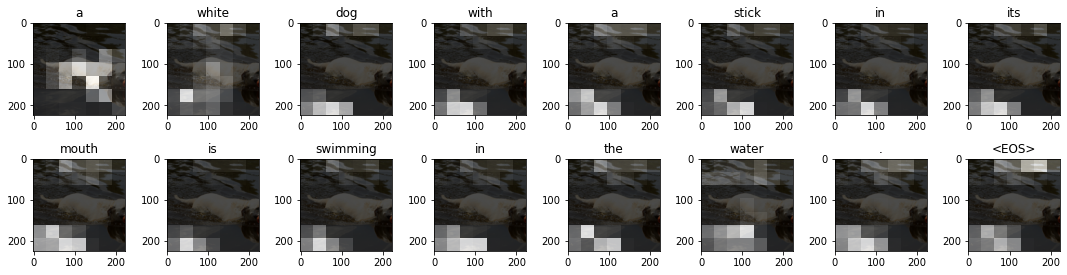

Generated BLEU Score 0.7469311382395961


In [151]:
#show any 1
dataiter = iter(data_loader)
images,cap = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas)

tot = []
for i in range(0,len(cap)):
    k = [dataset.vocab.itos[token] for token in cap[i].tolist()]
    tot.append(' '.join(k))

print('Generated BLEU Score',nltk.translate.bleu_score.sentence_bleu(tot,' '.join(caps),weights = (0.5,0.5)))

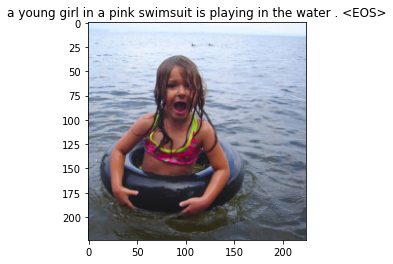

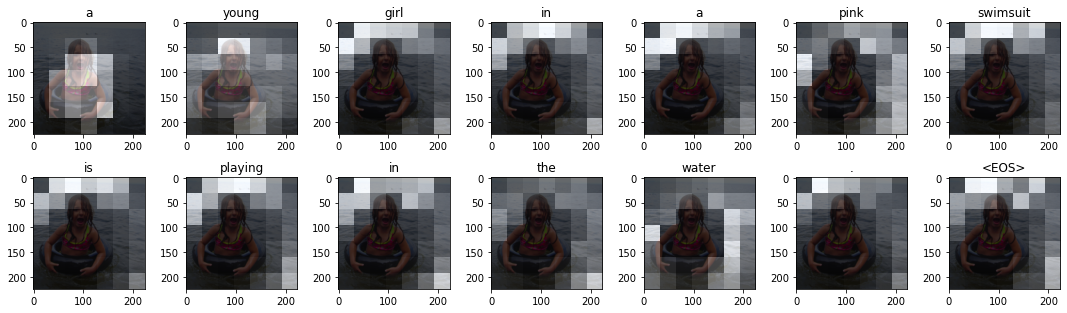

Generated BLEU Score 0.6452767045566646


In [147]:
# show any 1
dataiter = iter(data_loader)
images,_ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas)


tot = []
for i in range(0,len(cap)):
    k = [dataset.vocab.itos[token] for token in cap[i].tolist()]
    tot.append(' '.join(k))

print('Generated BLEU Score',nltk.translate.bleu_score.sentence_bleu(tot,' '.join(caps),weights = (0.5,0.5)))

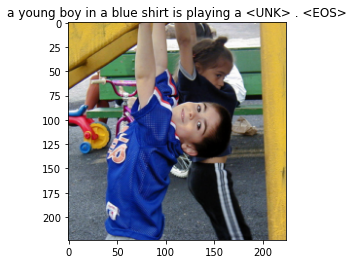

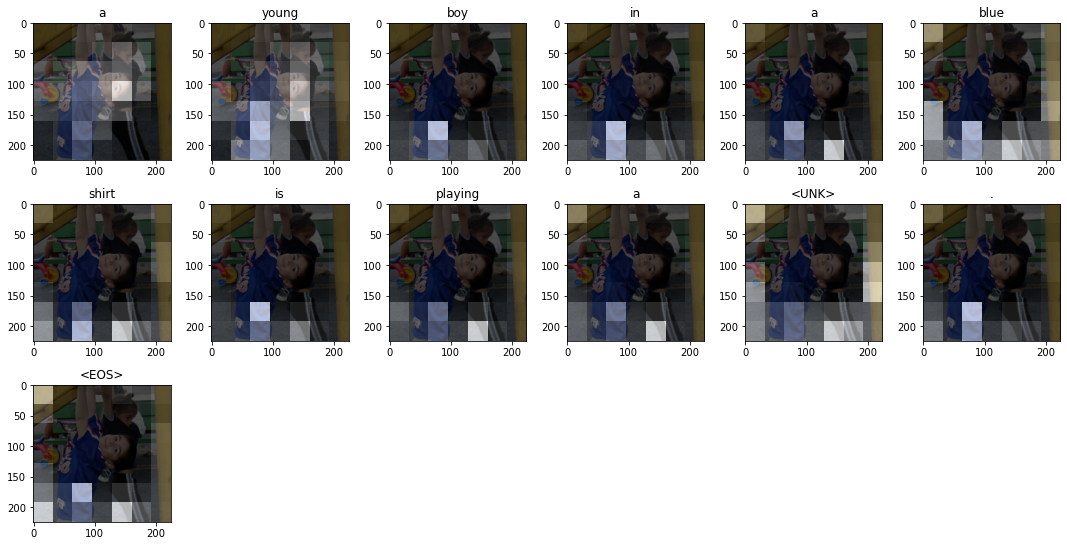

Generated BLEU Score 0.5298394135626106


In [149]:
# show any 1
dataiter = iter(data_loader)
images,_ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas)


tot = []
for i in range(0,len(cap)):
    k = [dataset.vocab.itos[token] for token in cap[i].tolist()]
    tot.append(' '.join(k))

print('Generated BLEU Score',nltk.translate.bleu_score.sentence_bleu(tot,' '.join(caps),weights = (0.5,0.5)))